# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
print("Working directory: ", os.getcwd())

import warnings
warnings.filterwarnings("ignore")

import sys
sys_dir = os.path.dirname(os.getcwd()
                          )
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)

INFO: Using numpy backend


Working directory:  /home/wanxinli/dyn
Directory added to path:  /home/wanxinli


## Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [4]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMeanClassifier
from geomstats.learning.pca import TangentPCA

import dyn.dyn.datasets.experimental as experimental
import dyn.dyn.features.basic as basic
import dyn.viz as viz

viz.init_matplotlib()
%config InlineBackend.figure_formats = ['svg']

We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metrics,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [5]:
dataset_name = "osteosarcoma"  # "osteosarcoma" #  "retinal"
# dataset_name = "retinal"
assert dataset_name in ["osteosarcoma", "retinal"]

if dataset_name == "osteosarcoma":
    n_cells = 650
    n_sampling_points = 100
    labels_a_name = "lines"
    labels_b_name = "mutations"
elif dataset_name == "retinal":
    # n_cells = 3871
    # n_sampling_points = 100
    n_cells = 100
    n_sampling_points = 10
    labels_a_name = "surfaces"
    labels_b_name = "mutations"

quotient = ["scaling", "rotation"]

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(os.getcwd(), f"dyn/saved_figs/{dataset_name}")
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H:%M:%S")
    print(now)

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
20230215_17:32:15


The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed.

In [6]:
if dataset_name == "osteosarcoma":
    cells, cell_shapes, labels_a, labels_b = experimental.load_treated_osteosarcoma_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )
    
else:
    cells, cell_shapes, labels_a, labels_b = experimental.load_mutated_retinal_cells(
        n_cells=n_cells, n_sampling_points=n_sampling_points, quotient=quotient
    )

... Selecting only a random subset of 650 / 650 cells.
... Interpolating: Cell boundaries have 100 samplings points.
... Removing potential duplicate sampling points on cell boundaries.

- Cells: quotienting translation.
- Cell shapes: quotienting scaling (length).
- Cell shapes: quotienting rotation.


In [7]:
print("cells shape is:", cells.shape)
print("cell_shapes shape is:", cell_shapes.shape)
print("labels_a shape is:", len(labels_a))
print("labels_b shape is:", len(labels_b))
print("n_cells is:", n_cells)

cells shape is: (650, 100, 2)
cell_shapes shape is: (650, 100, 2)
labels_a shape is: 650
labels_b shape is: 650
n_cells is: 650


In [8]:
def remove_control_cells(cells, cell_shapes, labels_a, labels_b):
    """ 
    Remove cells of control group from cells, cell_shapes, labels_a, labels_b,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells
    """

    # Find indices to delete
    delete_indices = []
    for i in range(len(labels_b)):
        if labels_b[i] == "control":
            delete_indices.append(i)
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    labels_a = list(np.delete(np.array(labels_a), delete_indices, axis=0))
    labels_b = list(np.delete(np.array(labels_b), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, labels_a, labels_b


def remove_cells(cells, cell_shapes, labels_a, labels_b, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, labels_a, labels_b,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    
    # Delete elements
    cells = np.delete(np.array(cells), delete_indices, axis=0)
    cell_shapes = np.delete(np.array(cell_shapes), delete_indices, axis=0)
    labels_a = list(np.delete(np.array(labels_a), delete_indices, axis=0))
    labels_b = list(np.delete(np.array(labels_b), delete_indices, axis=0))
    global n_cells
    n_cells = cells.shape[0]

    return cells, cell_shapes, labels_a, labels_b

In [9]:
print("cells shape is:", cells.shape)
print("cell_shapes shape is:", cell_shapes.shape)
print("labels_a shape is:", len(labels_a))
print("labels_b shape is:", len(labels_b))
print("n_cells is:", n_cells)

cells shape is: (650, 100, 2)
cell_shapes shape is: (650, 100, 2)
labels_a shape is: 650
labels_b shape is: 650
n_cells is: 650


### Preprocessing: Remove outliers by DeCOr-MDS using linear metric

In [10]:
from nsimplices import *
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric

# Prepare functions for calculating pairwise distances
def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [11]:
# compute pairwise distances
pairwise_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)

# run DeCOr-MDS
dim_start = 2
dim_end = 2
feature_num = 2
outlier_indices, subspace_dim , corr_pairwise_dis, corr_coord = nsimplices(pairwise_dists, feature_num, dim_start, dim_end, std_multi=2)


INFO: finding looplift candidates


In [12]:
""" 
Remove cells
"""

# Find indices for cells that are dlm8

cells, cell_shapes, labels_a, labels_b = remove_cells(cells, cell_shapes, labels_a, labels_b, outlier_indices)

In [13]:
print("cells shape is:", cells.shape)
print("cell_shapes shape is:", cell_shapes.shape)
print("labels_a shape is:", len(labels_a))
print("labels_b shape is:", len(labels_b))
print("n_cells is:", n_cells)

cells shape is: (622, 100, 2)
cell_shapes shape is: (622, 100, 2)
labels_a shape is: 622
labels_b shape is: 622
n_cells is: 622


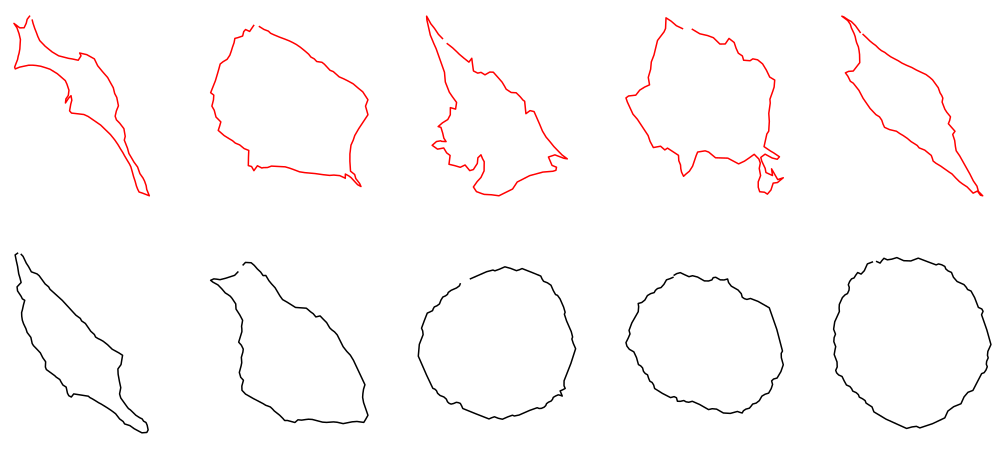

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the some outlier cells and some normal cells

normal_indices=[i for i in range(pairwise_dists.shape[0]) if i not in outlier_indices] # list of normal points 

fig = plt.figure(figsize=(18, 8))

nrows = 2
ncols = 5 # plot 3 normal cells, and 3 outlier cells

# plot outlier cells
for i in range(ncols):
    outlier_index = outlier_indices[i]
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.plot(cell_shapes[outlier_index, :, 0], cell_shapes[outlier_index, :, 1], "red")
    ax.set_aspect("equal")
    ax.axis("off")
    

# plot normal cells
for i in range(ncols):
    normal_index = normal_indices[i]
    ax = fig.add_subplot(nrows, ncols, i+1+ncols)
    ax.plot(cell_shapes[normal_index, :, 0], cell_shapes[normal_index, :, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")

plt.show()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_normal_outlier.svg"))

In [15]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)

Dictionary associated to label "lines":
{'dlm8': 0, 'dunn': 1}
Dictionary associated to label "mutations":
{'control': 0, 'cytd': 1, 'jasp': 2}


## Define Shape Spaces

In [16]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

In [17]:
METRICS

{'Linear': <geomstats.geometry.discrete_curves.L2CurvesMetric at 0x7f5396a95280>,
 'SRV': <geomstats.geometry.discrete_curves.SRVMetric at 0x7f53c25476d0>}

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [18]:
means = {}

means["Linear"] = gs.mean(cell_shapes, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cell_shapes).estimate_

In [19]:
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            method="default").fit(cell_shapes).estimate_

In [20]:
print(means['SRV'])

[[-0.0591203   0.12958138]
 [-0.06220998  0.12798601]
 [-0.06531641  0.12585987]
 [-0.06822055  0.12315472]
 [-0.07094351  0.11992782]
 [-0.07333759  0.11633884]
 [-0.07572082  0.11266447]
 [-0.07788821  0.10864307]
 [-0.07989942  0.10427152]
 [-0.08156578  0.09994728]
 [-0.08303382  0.0955071 ]
 [-0.08442235  0.0908986 ]
 [-0.08567366  0.08595948]
 [-0.08673913  0.08107775]
 [-0.08746102  0.07665164]
 [-0.08787293  0.07229818]
 [-0.08809127  0.06770528]
 [-0.08799176  0.06315806]
 [-0.08781644  0.05883082]
 [-0.08735355  0.05438706]
 [-0.08663615  0.04944702]
 [-0.08558374  0.04495174]
 [-0.08437501  0.03996439]
 [-0.08312085  0.03509209]
 [-0.08140557  0.03048537]
 [-0.07946002  0.02627432]
 [-0.07759107  0.02219794]
 [-0.07531399  0.01836372]
 [-0.07269246  0.01425299]
 [-0.06980473  0.01016866]
 [-0.06679962  0.00613618]
 [-0.06408053  0.00249949]
 [-0.06127042 -0.00089022]
 [-0.05826767 -0.00405095]
 [-0.05492691 -0.00694746]
 [-0.05136441 -0.01014783]
 [-0.04771555 -0.01279196]
 

We plote the cell shapes corresponding to the means with different metrics.

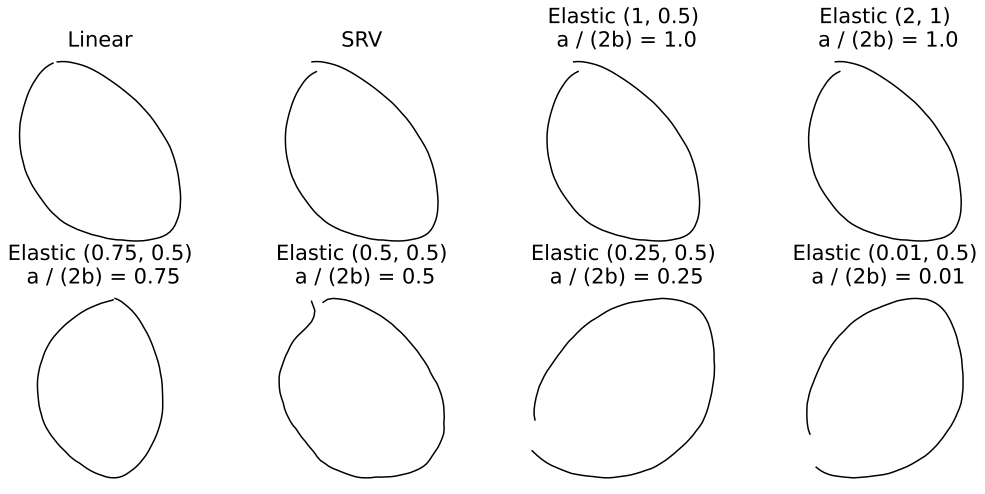

In [21]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
    
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_open_means.svg"))

We attempt to plot the closed versions of these means:

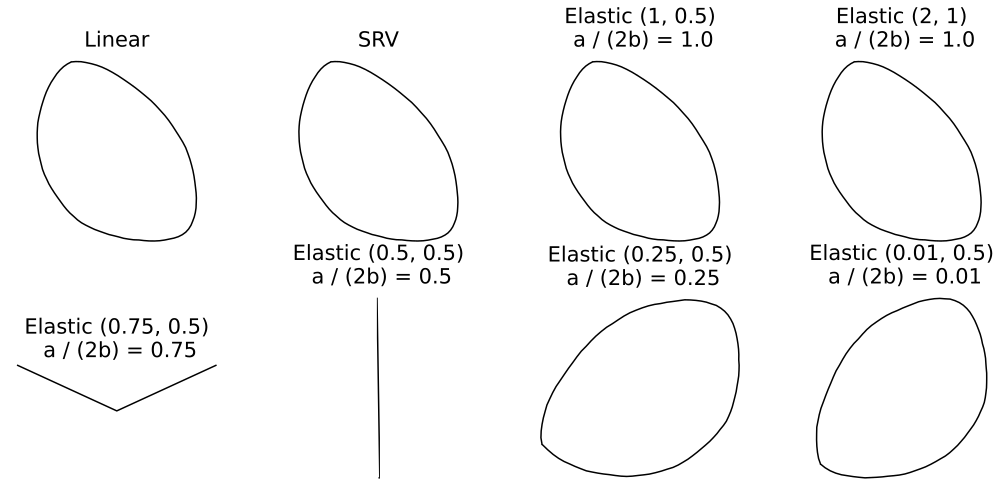

In [22]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_closed_means.svg"))

**Remark:** Unfortunately, there are some numerical issues with the projection in the space of closed curves, as shown by the V-shaped results above.

Since ratios of 1 give the same results as for the SRV metric, we only select AS, BS with a ratio that is not 1 for the elastic metrics.

We also continue the analysis with the space of open curves, as opposed to the space of closed curves, for the numerical issues observed above.

In [23]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell in the dataset
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [24]:
dists = {}

dists["Linear"] = [gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cells]

dists["SRV"] = [
    SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cells
]

for a, b in zip(NEW_AS, NEW_BS):
    dists[a, b] =  [
    ELASTIC_METRIC[a, b].dist(means[a, b], cell) / n_sampling_points for cell in cells
]

In [25]:
dists_summary = pd.DataFrame(
    data={
        labels_a_name: labels_a,
        labels_b_name: labels_b,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

for a, b in zip(NEW_AS, NEW_BS):
    dists_summary[f"Elastic({a}, {b})"] = dists[a, b]

In [26]:
dists_summary.head()

,lines,mutations,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,dlm8,control,5.742362,0.196459,0.197439,0.199105,0.195905,0.192765
1,dlm8,control,4.016103,0.164965,0.165937,0.167223,0.163912,0.160867
2,dlm8,control,1.872706,0.104809,0.105268,0.107399,0.104573,0.101327
3,dlm8,control,1.606625,0.099155,0.099072,0.101333,0.098542,0.095066
4,dlm8,control,1.872599,0.106058,0.106446,0.108672,0.105808,0.102451


In [27]:
print(len(dists_summary))

622


In [28]:
xx = {}

for metric_name in ["Linear", "SRV"]:
    min_dists = gs.array(min(dists_summary[metric_name]))
    max_dists = gs.array(max(dists_summary[metric_name]))
    xx[metric_name] = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)

In [29]:
def hist_dists_to_means(labels, labels_name, label_color_incr):
    """ 
    To the global mean
    """
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        for i_lab, label in enumerate(np.unique(labels)):
            if label == "control":
                continue
            ds = dists_summary[dist_name][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)

            axs[i].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n {dist_name} mean\n colored by {labels_name}\n ")


    fig, axs = plt.subplots(1, len(NEW_AS), figsize=(18, 2), sharey=True)

    for i, (a, b) in enumerate(zip(NEW_AS, NEW_BS)):
        for i_lab, label in enumerate(np.unique(labels)):
            if label == "control":
                continue
            ds = dists_summary[f"Elastic({a}, {b})"][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)
            axs[i].plot(xx[metric_name], kde(xx[metric_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by {labels_name}\n")

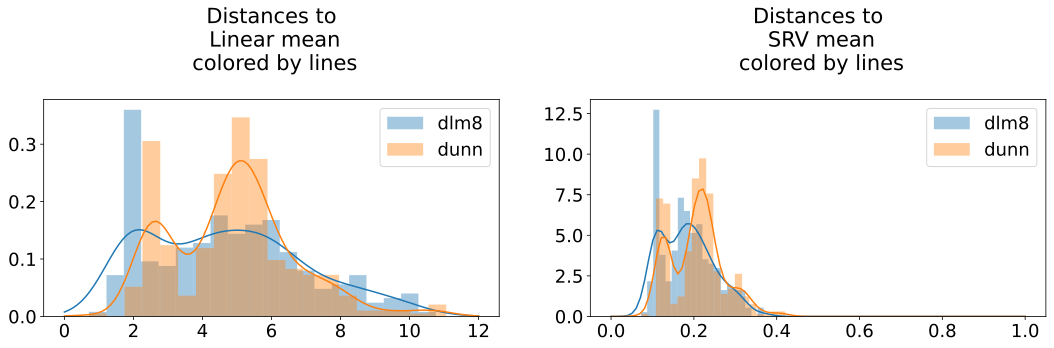

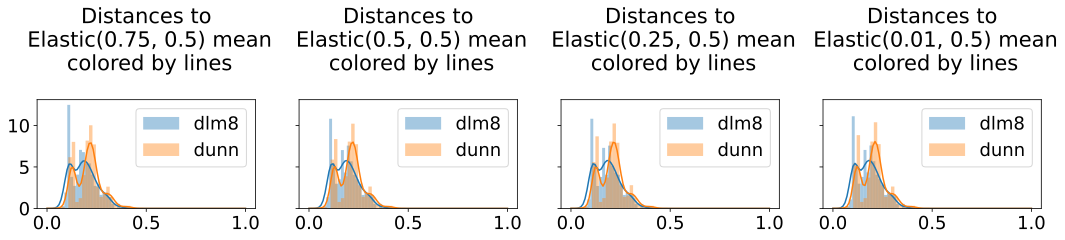

In [30]:
hist_dists_to_means(labels_a, labels_a_name, label_color_incr=0)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_by_{labels_a_name}.svg"))

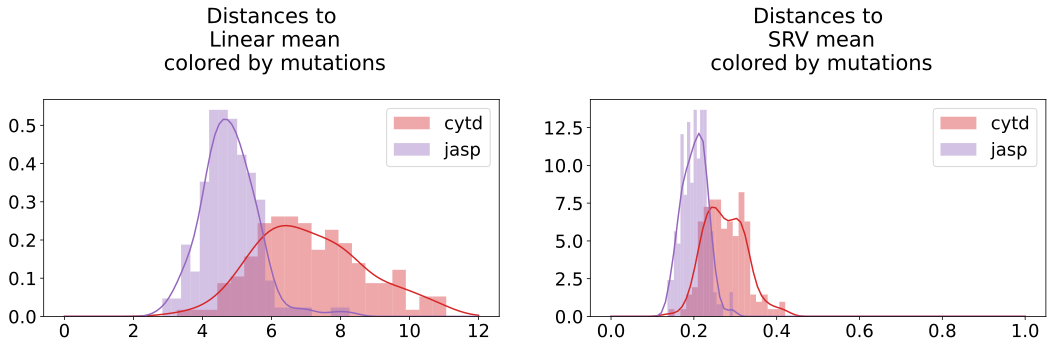

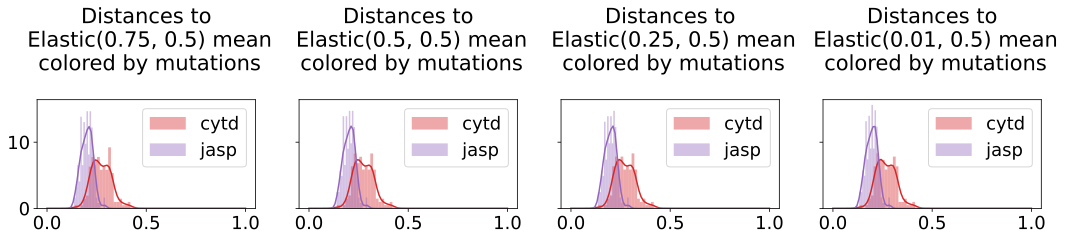

In [31]:
hist_dists_to_means(labels_b, labels_b_name, label_color_incr=2)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_by_{labels_b_name}.svg"))

We observe that the histograms of distances vary between the:
- the histogram of distances to the linear mean
- the histogram of distances to the SRV mean.

For example, regarding the histograms colored by cell lines:
- the distributions of distances to the linear mean barely show a bimodal distribution for each of the cell lines.
- while the distributions of distances computed with the SRV metric clearly show 3 modes in each of the cell lines, that correspond to the 3 treatments.

For example, regarding the histograms colored by treatments:
- the distributions of distances to the linear mean only show control and jasp that are superimposed,
- while the distributions of distances computed with the SRV metric clearly show 3 separated distributions.

We also observe that the histogram of cytd (in red) shows two modes, that correspond to the two lines: this bimodality had not been observed on the histograms of distances to the Linear mean.


However, the histograms of distances to the Elastic means show very little difference from the histogram to the SRV mean.

Thus, for the remainder of this analysis, we focus on the comparison between the Linear mean and the SRV mean.

In [32]:
def full_hist_dists_to_means_split():
    for i, dist_name in enumerate(["Linear", "SRV"]):
        fig, axs = plt.subplots(len(np.unique(labels_a)), len(np.unique(labels_b)), figsize=(18, 8))
        for i_lab_a, label_a in enumerate(np.unique(labels_a)):
            for i_lab_b, label_b in enumerate(np.unique(labels_b)):
                ds = dists_summary[dist_name][
                    dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
                axs[i_lab_a, i_lab_b].hist(
                    ds, bins=20, alpha=0.4, density=True, label=label_a+"-"+label_b, color=f"C{i_lab_a+2*i_lab_b}"
                )
                kde = stats.gaussian_kde(ds)

                axs[i_lab_a, i_lab_b].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab_a+2*i_lab_b}")
                axs[i_lab_a, i_lab_b].legend()
                axs[i_lab_a, i_lab_b].set_title(f"Distances to {dist_name} mean ")
        plt.tight_layout()

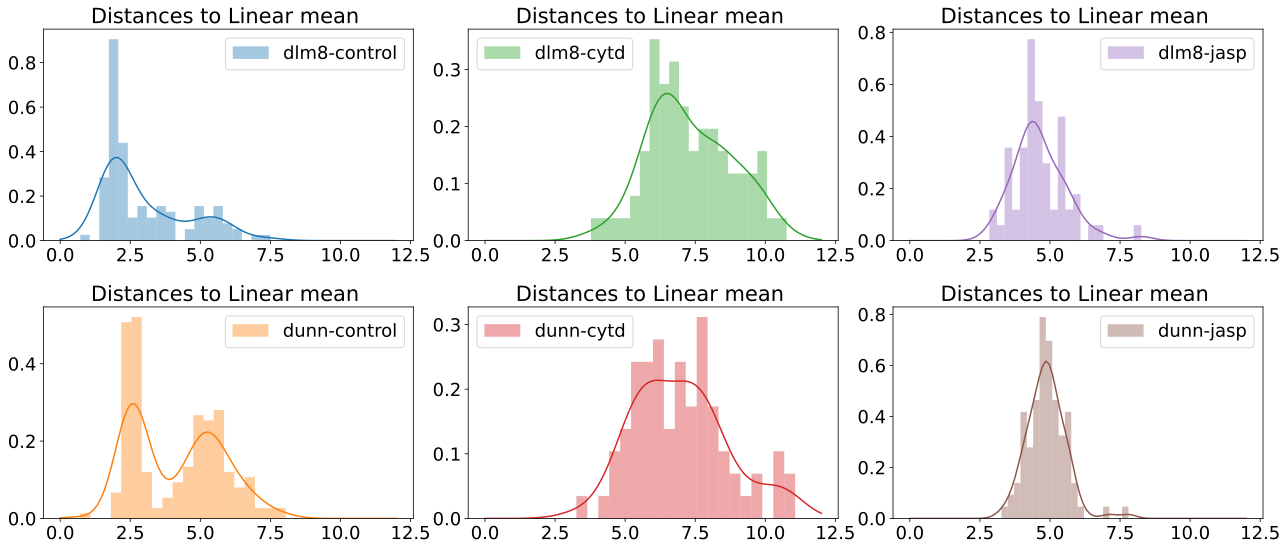

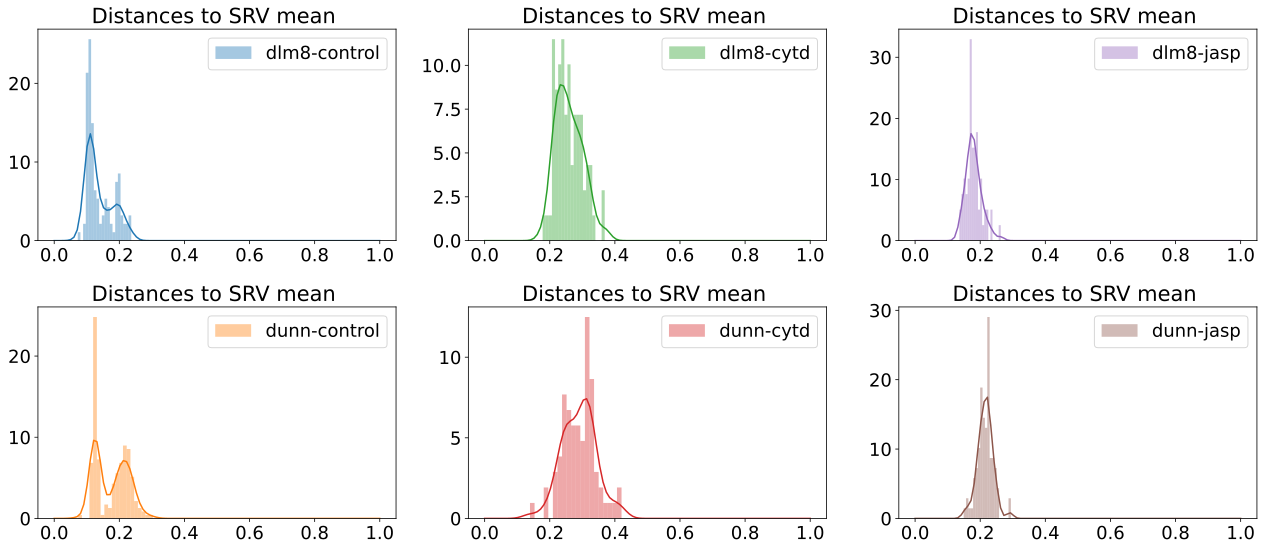

In [33]:
full_hist_dists_to_means_split()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_all_split.svg"))

In [34]:
def full_hist_dists_to_means_gather():
    for i, dist_name in enumerate(["Linear", "SRV"]):
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        for i_lab_a, label_a in enumerate(np.unique(labels_a)):
            for i_lab_b, label_b in enumerate(np.unique(labels_b)):
                ds = dists_summary[dist_name][
                    dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
                axs.hist(
                    ds, bins=20, alpha=0.4, density=True, label=label_a+"-"+label_b, color=f"C{i_lab_a+2*i_lab_b}"
                )
                kde = stats.gaussian_kde(ds)

                axs.plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab_a+2*i_lab_b}")
                axs.legend()
                axs.set_title(f"Distances to {dist_name} mean ")
        plt.tight_layout()

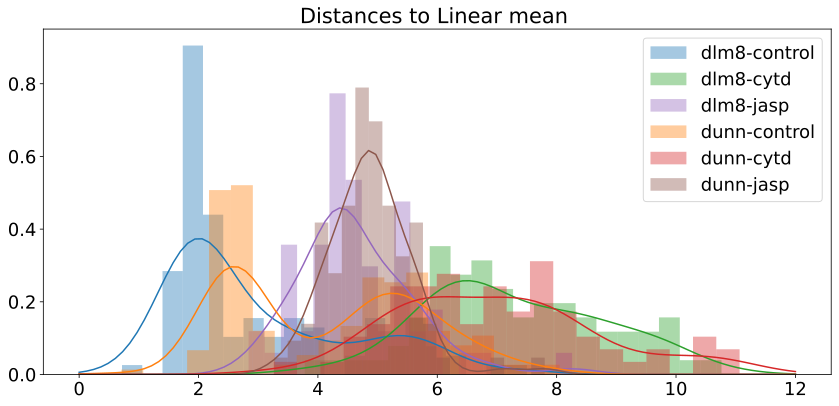

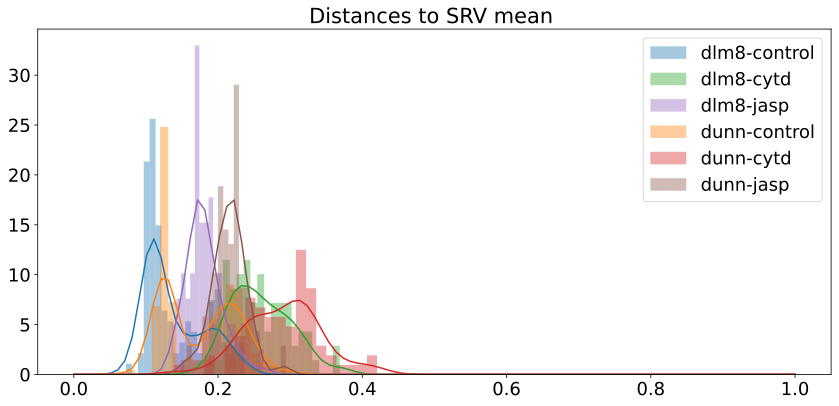

In [35]:
full_hist_dists_to_means_gather()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_all_gather.svg"))

# Distance to own means

# Clustering on distances with KMeans

We investigate whether KMeans performs differently when used with:
- the distances to the linear mean,
- the distances to the SRV mean.

In [36]:
def reorder_confusion_matrix(cmat):
    def _make_cost_m(cm):
        s = np.max(cm)
        return -cm + s

    indexes = linear_assignment(_make_cost_m(cmat))
    js = sorted(indexes, key=lambda x: x[0])[1]
    cm2 = cmat[:, js]
    return cm2

In [37]:
def confusion_kmean(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)
        kmeans = KMeans(n_clusters=len(labels_dict), random_state=0).fit(dists_arr)
        true_labels = [labels_dict[lab] for lab in labels]
        cm = confusion_matrix(true_labels, kmeans.labels_)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].axes.yaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].set_xlabel("Kmeans labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Clustering {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc:.2f}%")

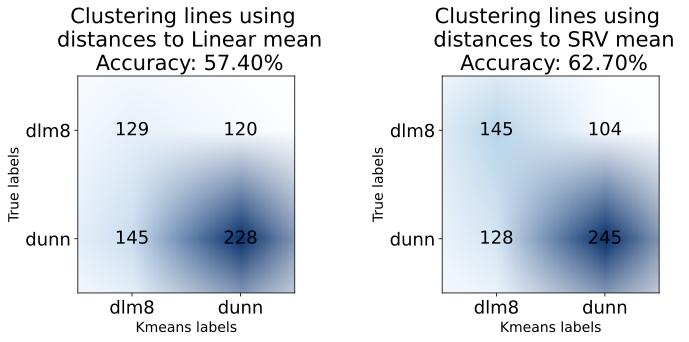

In [38]:
confusion_kmean(labels_a, labels_a_name, labels_a_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_a_name}.svg"))

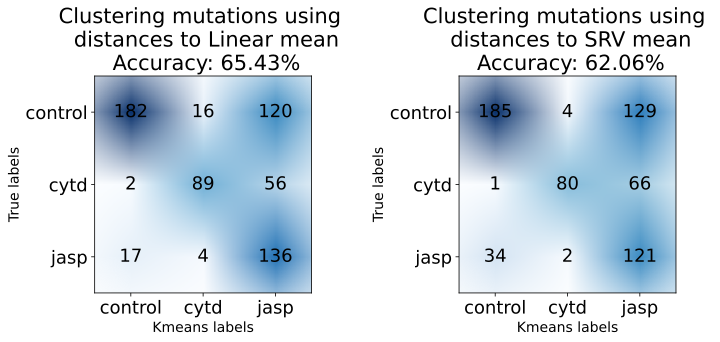

In [39]:
confusion_kmean(labels_b, labels_b_name, labels_b_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_b_name}.svg"))

# Classification with Euclidean MDM and Riemannian MDM

In [40]:
def confusion_mdm(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    true_labels_ints = [labels_dict[lab] for lab in labels]

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)        
        
        means_of_each_label = []
        for i_lab, lab in enumerate(np.unique(labels)):
            means_of_each_label.append(np.mean(  # mean of scalars in both cases
                dists_summary[dist_name][dists_summary[labels_name] == lab]))
        pred_labels_ints = []  
        for dist_cell in dists_arr:
            distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
            pred_labels_ints.append(np.argmin(distdists))
        
        cm = confusion_matrix(true_labels_ints, pred_labels_ints)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].axes.yaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].set_xlabel("MDM labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Classifying {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc:.2f}%")

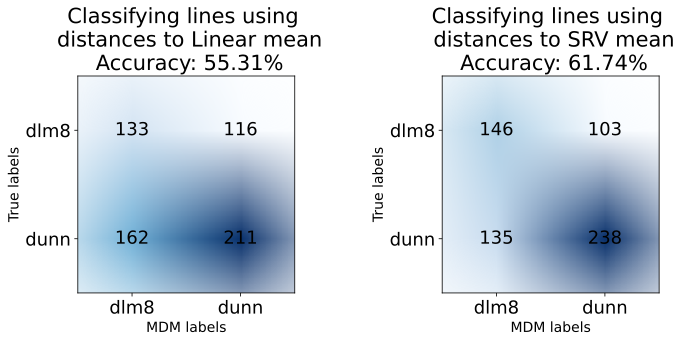

In [41]:
confusion_mdm(labels_a, labels_a_name, labels_a_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_classification_by_{labels_a_name}.svg"))

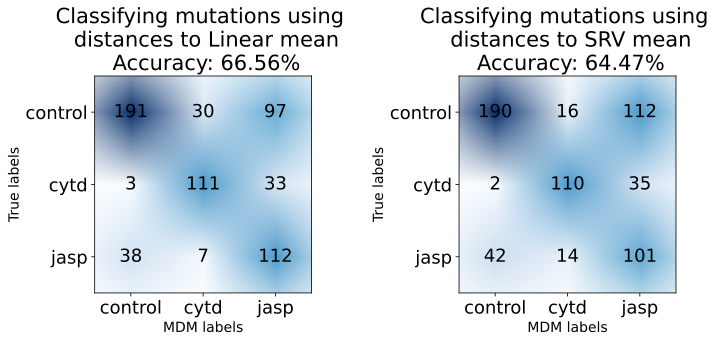

In [42]:
confusion_mdm(labels_b, labels_b_name, labels_b_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_b_name}.svg"))

In both the unsupervised and supervised cases, we observe that some controls are clustered/classified as jasp. This makes sense from the histogram of distances, where we see that there is peak in the control distribution beneath the principal mode of the jasp distribution.

# Dimension Reduction with PCA and tPCA

We investigate whether PCA and its Manifold equivalent (tangent PCA) performs differently when used with:
- the Euclidean (linear) metric,
- the SRV metric.

In [43]:
cells_flat = gs.reshape(cells, (len(cells), -1))

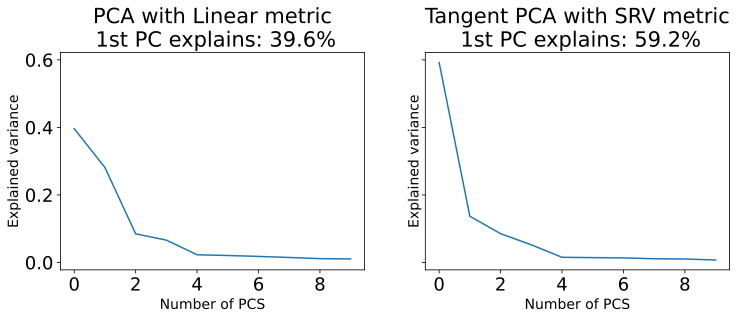

In [44]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, metric_name in enumerate(["Linear", "SRV"]):
    axs[i].plot(pcas[metric_name].explained_variance_ratio_)
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")
    tangent = ""
    if metric_name == "SRV":
        tangent = "Tangent "
    first_pc_explains = 100*sum(pcas[metric_name].explained_variance_ratio_[:1])
    axs[i].set_title(f"{tangent}PCA with {metric_name} metric\n 1st PC explains: {first_pc_explains:.1f}%")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_explained_variance.svg"))

We observe that the first principal components of the tangent PCA using the SRV metric captures a larger portion of the variance.

The first two components of the PCA with the Linear metric captures the following variance ratio:

In [45]:
sum(pcas["Linear"].explained_variance_ratio_[:1])

0.39623564602877925

The first two components of the tangent PCA with the SRV metric captures the following variance ratio:

In [46]:
sum(pcas["SRV"].explained_variance_ratio_[:1])

0.592236814745121

We explore the projections of the cell data on the two principal components of each PCA.

The projections on the PCA of the SRV metric are more informative, as they have captured more variance.

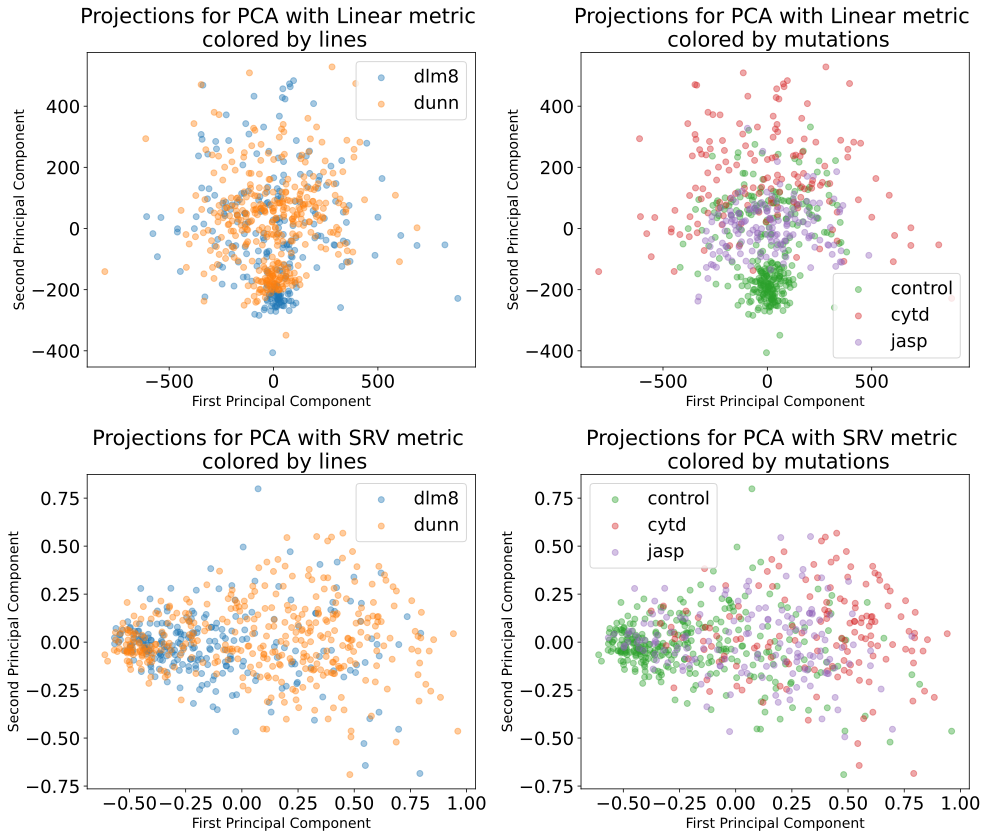

In [47]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i, j].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label
            )
            axs[i, j].set_xlabel("First Principal Component")
            axs[i, j].set_ylabel("Second Principal Component")
            axs[i, j].set_title(
                f"Projections for PCA with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_projections_2d.svg"))

In [48]:
times = np.arange(-0.5, 0.5, 0.1)

def plot_pc(geod, i_pc, metric_name):
    fig = plt.figure(figsize=(8, 1.3))
    for i, curve in enumerate(geod):
        fig.add_subplot(1, len(times), i + 1)
        plt.plot(curve[:, 0], curve[:, 1], c=f"C{i_pc+6}")
        plt.axis("equal")

        plt.axis("off")
        plt.tight_layout()
    fig.suptitle(f"Principal Component {i_pc} for {metric_name} metric")

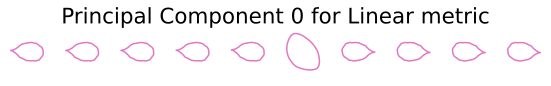

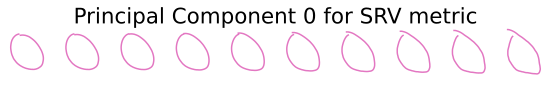

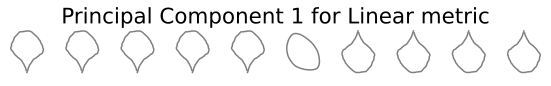

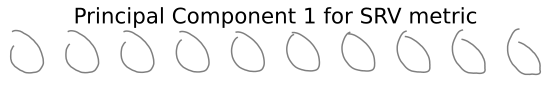

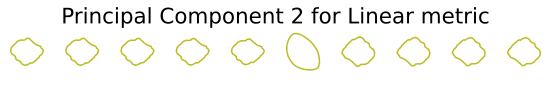

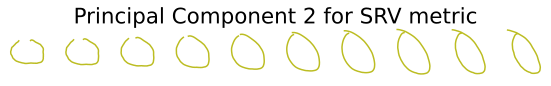

In [49]:
n_pcs = 3

for i_pc in range(n_pcs):
    pc = means["Linear"] + np.einsum(
        "n,ij->nij", 300 * times, pcas["Linear"].components_[i_pc].reshape((n_sampling_points, 2))
    )
    plot_pc(pc, i_pc=i_pc, metric_name="Linear")

    gpc = SRV_METRIC.geodesic(
        initial_curve=means["SRV"],
        initial_tangent_vec=pcas["SRV"].components_[i_pc].reshape((n_sampling_points, 2)),
    )(times)

    plot_pc(gpc, i_pc=i_pc, metric_name="SRV")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_{n_pcs}_pcs.svg"))

Traversing a principal component using the Euclidean (Linear) metric does not seem to provide interesting insights on the variations within the datasets of cells. The curve shapes mostly seems to be rotating, which gives an explanation of why the pca space showcases some semi-circles. However, rotation is not part of the shape.

# Dimension Reduction via MDS

We examine another dimension reduction technique: Multidimensional Scaling (MDS).

MDS relies on computing the (pairwise) distances between any two pairs of cells, which we do first using just in time compilation (jit) to speed up the computations.

In [50]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points

def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

def elastic_dist(cell1, cell2):
    return ELASTIC_METRIC[(1, 0.5)].dist(cell1, cell2)/ n_sampling_points

In [51]:
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

In [52]:
print(cells.shape)

(622, 100, 2)


In [53]:
pairwise_dists = parallel_dist(cells, dist_fun=linear_dist)

INFO: finding looplift candidates


In [54]:
print(pairwise_dists.shape)

(622, 622)


In [55]:
# This takes 7min
pairwise_srv_dists = parallel_dist(cells, dist_fun=srv_dist)

In [56]:
print(pairwise_srv_dists.shape)

(622, 622)


In [57]:
mds = {}
pos = {}

mds["Linear"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_

mds["SRV"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_

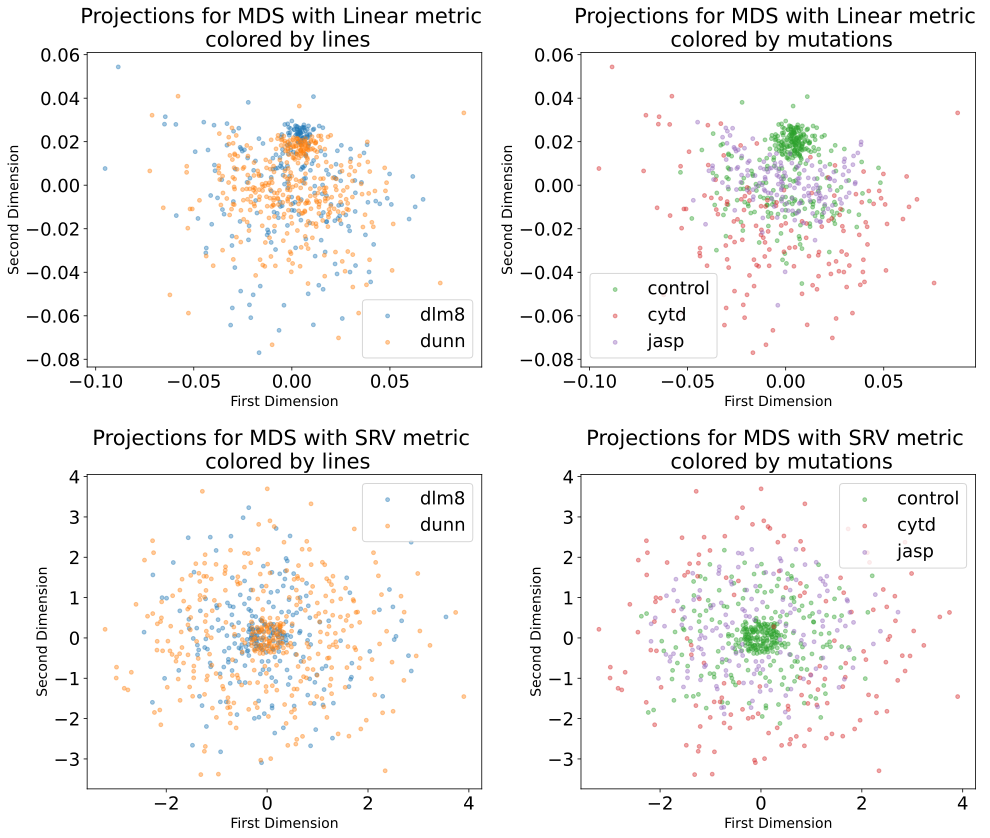

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axs[i, j].scatter(
                position[:, 0],
                position[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axs[i, j].set_xlabel("First Dimension")
            axs[i, j].set_ylabel("Second Dimension")
            axs[i, j].set_title(
                f"Projections for MDS with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_mds_projections_2d.svg"))

Interestingly, the MDS with the distances computed from the SRV metric shows a concentric organization of the treatment. The distance to the origin (0, 0) of the space seems related to the treatment.

We sample cell shapes around circles of different radii to explore whether the polar angle contains relevant information.

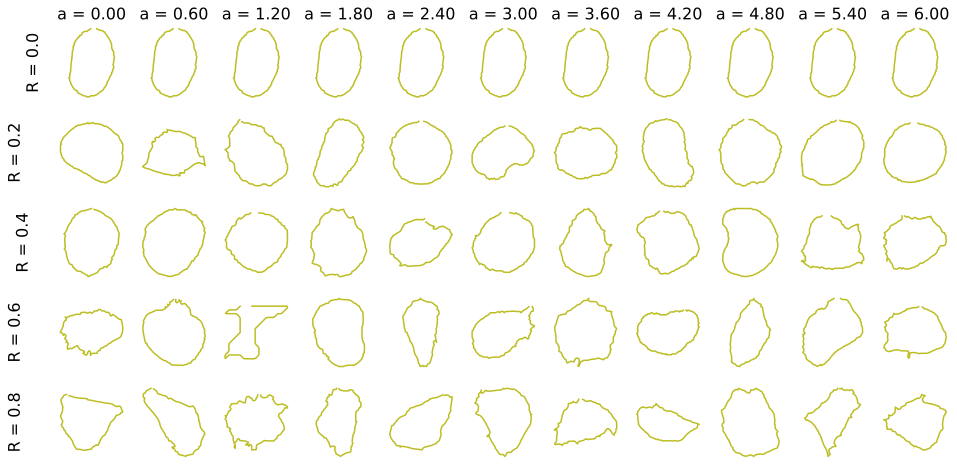

In [59]:
fig = plt.figure(figsize=(16, 8))
thetas = np.arange(0, 2 * np.pi, 0.6)
radii = np.arange(0, 0.001, 0.0002)

left, width = -.5, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

count = 0
for i_radius, radius in enumerate(radii):
    for i_theta, theta in enumerate(thetas):
        ax = fig.add_subplot(len(radii), len(thetas), count + 1)

        pos_theta = np.array([radius * np.cos(theta), radius * np.sin(theta)])
        dists_theta = np.linalg.norm(pos_theta - pos["SRV"], axis=1)
        assert len(dists_theta) == n_cells
        idx = np.argmin(dists_theta)

        ax.plot(cells[idx][:, 0], cells[idx][:, 1], c=f"C{i_pc+6}")
        ax.set_aspect("equal")
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i_radius == 0:
            ax.set_title(f"a = {theta:.2f}", fontsize=16)
        if i_theta == 0:
            ax.text(-0.5, 0.5 * (bottom + top), f"R = {1000 * radius:.1f}", # rescaling for visualization
                horizontalalignment='right',
                verticalalignment='center',
                rotation='vertical',
                transform=ax.transAxes,
                fontsize=16)
        count += 1
    plt.ylabel(f"Radius: {radius}")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_mds_from_radius_and_angle.svg"))

The following scatter plot shows that the radius in MDS space is the distance to the SRV mean shape.

In [60]:
from scipy.stats import gaussian_kde

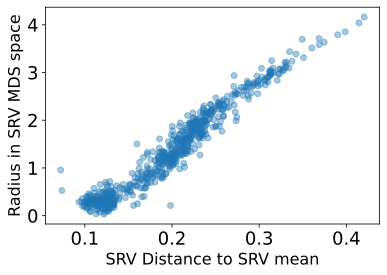

In [61]:
plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_mds_radius_and_srv_dist.svg"))

(622, 2)


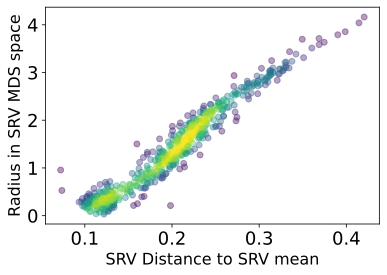

In [62]:
points_to_plot = gs.stack([dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1)], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4, c=z_norm)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_mds_radius_and_srv_dist.svg"))

# SRV distance and area, perimeter

In [63]:
areas = []
lengths = []
features = []
for cell in cells:
    area = basic.area(cell)
    length = basic.perimeter(cell)
    areas.append(area)
    lengths.append(length)
    features.append(area / length)

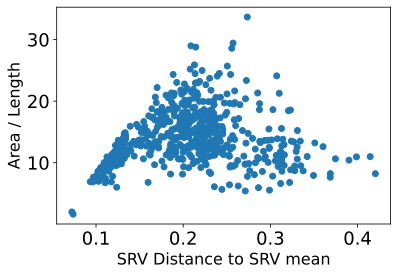

In [64]:
plt.scatter(dists_summary["SRV"], features);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_arealength_and_srv_dist.svg"))

(622, 2)


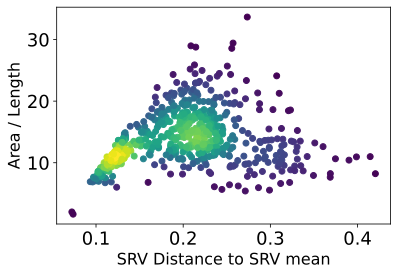

In [65]:
points_to_plot = gs.stack([dists_summary["SRV"], features], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(dists_summary["SRV"], features, c=z_norm);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_arealength_and_srv_dist.svg"))

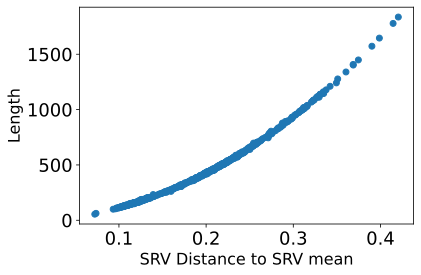

In [66]:
plt.scatter(dists_summary["SRV"], lengths);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_length_and_srv_dist.svg"))

(622, 2)


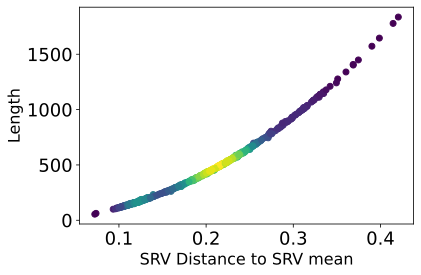

In [67]:
points_to_plot = gs.stack([dists_summary["SRV"], lengths], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
plt.scatter(dists_summary["SRV"], lengths, c=z_norm);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_length_and_srv_dist.svg"))

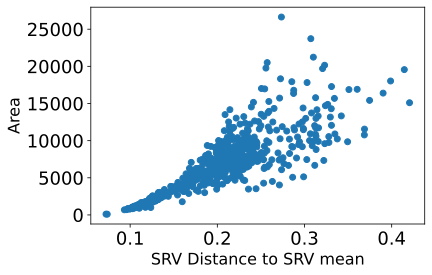

In [68]:
plt.scatter(dists_summary["SRV"], areas);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_area_and_srv_dist.svg"))

We observe an almost perfect nonlinear correlation with the lenght of the curve. This is expected since the srv space is a space describing irregularities of the border of the cell, and irregularities are correlated with longer perimeter of a curve, -- for an equivalent area.

However, we note that the SRV space also provides additional degrees of symmetries, such that one can traverse this space, compute geodesics, computes means on a much complex object (the cell shape) than on just the length of the curve.

(622, 2)


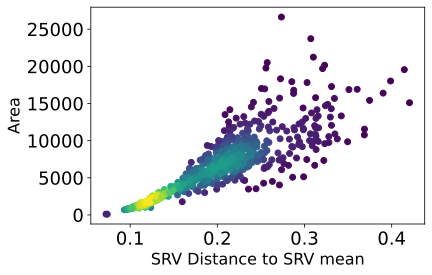

In [69]:
points_to_plot = gs.stack([dists_summary["SRV"], areas], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
plt.scatter(dists_summary["SRV"], areas,  c=z_norm);

plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_area_and_srv_dist.svg"))